In [17]:
using DataFrames, LogTopReg, Distributions, 

In [313]:
K = 2;
σ_μ = 0.5;
σ = 1.0;
σ_β = 0.0;
σ_A = linspace(0.0,0.0,K)

n = 400;
p = 2;
nd = repeat([50],inner=[n]);
guh = sample([0.0,1.0],n);
A = guh*guh' + I;
UA = chol(A);
y = Vector{Array{Int64,2}}(n);
μ = randn(K)*σ_μ;
β = randn(K,p)*σ_β;
X = randn(p,n);
g = randn(K,n)*UA;

In [314]:
softmax(μ)

2-element Array{Float64,1}:
 0.482428
 0.517572

In [315]:
θ = linspace(0.1,K*2,K).^2;
η = Array{Float64}(K,n);
nk = Array{Int64}(K,n);
for i in 1:n
    η[:,i] = randn(K).*σ .+ μ + β*X[:,i] + σ_A.*g[:,i];
    nk[:,i] = rand(Multinomial(nd[i],softmax(η[:,i])));
    y[i] = hcat(map(j -> hcat(rand(Poisson(θ[j]),nk[j,i]),rand(Poisson(θ[K:-1:1][j]),nk[j,i]))', 1:K)...);
end

In [ ]:
η

In [316]:
pss0 = VectorPosterior(PoissonPosterior(0.1,0.1),2);
niter = 500;
thin = 1;
ns = div(niter,thin);

In [339]:
@time fit = topiclmm(y,X,convert(Array{Float64,2},UA),pss0,K,
    hyperparameter(ν0_u=0.25,τ0_u= 0.01,τ_β=0.0001),iter=niter);

 81.120059 seconds (353.10 M allocations: 43.421 GB, 19.64% gc time)


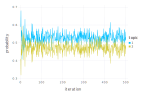

In [340]:
using Gadfly
mudat = DataFrame(probability = mapslices(softmax,fit[:μ],1)[:],topic=repeat(map(string,1:K),outer=[ns]),
iteration=repeat(collect(1:ns),inner=[K]));
plot(mudat,x="iteration",y="probability",color="topic",Geom.line)

In [342]:
fit[:τ_u][2,:]

500-element Array{Float64,1}:
 0.22816 
 0.212546
 0.236342
 0.230029
 0.268004
 0.271092
 0.306427
 0.296442
 0.266463
 0.264008
 0.228297
 0.258991
 0.236843
 ⋮       
 0.328837
 0.330636
 0.323354
 0.330457
 0.348884
 0.408508
 0.364615
 0.461894
 0.438434
 0.437298
 0.481568
 0.510792

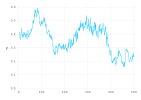

In [344]:
σ2Ahat = fit[:τ_u][2,:].*fit[:σ2][2,:]+fit[:τ_u][1,:].*fit[:σ2][1,:];
σ2hat = fit[:σ2][2,:] + fit[:σ2][1,:];
h2 = σ2Ahat./(σ2hat.+σ2Ahat)

plot(y=h2,Geom.line)

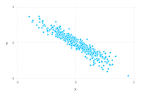

In [320]:
plot(y=η[1,:]-η[2,:].-μ[1].+μ[2],x=fit[:η][1,:,500] - fit[:η][2,:,500] .- fit[:μ][1,500] .+ fit[:μ][2,500])

In [321]:
resid1 = fit[:η][1,:,500] .- X'*fit[:β][:,1,500] .- fit[:μ][1,500] .- UA'*fit[:u][:,1,500];
resid2 = fit[:η][2,:,500] .- X'*fit[:β][:,2,500] .- fit[:μ][2,500] .- UA'*fit[:u][:,2,500];
var(resid1-resid2)

0.6105861120018394

In [322]:
size(fit[:σ2])

(2,500)

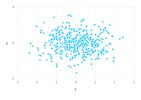

In [323]:
plot(x=mean( (UA'*fit[:u][:,1,:]-UA'*fit[:u][:,2,:])[:,101:500] ,2),y=g[1,:]-g[2,:],Geom.point)